# CRAG: Corrective RAG


## OverView


**The Corrective RAG (CRAG)** strategy focuses on improving RAG-based systems.
**CRAG** is an approach that refines the search-generation pipeline by incorporating self-reflection and self-evaluation phases for the retrieved documents.

![crag](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/03-Use-Cases/assets/03-Langgraph-CRAG.png?raw=1)



**What is CRAG ?**

**Corrective-RAG (CRAG)** is a methodology in the RAG (Retrieval-Augmented Generation) strategy that **adds a step to evaluate the retrieved documents and refine the knowledge.** This approach involves reviewing the search results before generation, conducting supplementary searches if necessary, and ultimately includes a series of processes to produce high-quality responses.

The core ideas of CRAG are as follows:

[Link to the paper (Corrective Retrieval-Augmented Generation)](https://arxiv.org/pdf/2401.15884.pdf)

1. If one or more of the retrieved documents exceed the predefined relevance threshold (retrieval validation score), the process proceeds to the generation stage.
2. A knowledge refinement step is performed before generation.
3. Documents are divided into "knowledge strips" (where ```k``` refers to the number of document retrieval results).
4. Each knowledge strip is evaluated, and its relevance is scored (evaluations are conducted at the document chunk level).
5. If all documents fall below the relevance threshold or the evaluation results have low confidence, additional data sources (e.g., web searches) are used for supplementation.
6. When supplementing through web searches, query results are optimized using ```Query-Rewrite```.
---

**Key Points**


This tutorial demonstrates implementing some of the ideas from the ```CRAG``` approach using LangGraph.

Here, **the knowledge refinement step is omitted** but is designed to be added as a node if necessary.

Additionally, **if no relevant documents are found**, ```web searches``` will be used to supplement the retrieval.

For **web searches**,  [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search/) will be utilized, and Question Rewrite will be introduced to optimize the search process.

---

**Overview of Key Steps**

- **Retrieval Grader**: Evaluate the relevance of the retrieved documents.
- **Generate**: Generate answers using LLM.
- **Question Re-writer**: Optimize search queries by rewriting the question.
- **Web Search Tool**: Utilize Tavily Search for web searches.
- **Create Graph**: Create a CRAG strategy graph using LangGraph.
- **Use the graph**: Learn how to utilize the generated graph.





### References
https://langchain-opentutorial.gitbook.io/langchain-opentutorial/17-langgraph/03-use-cases/03-langgraph-crag
- [LangGraph: Corrective RAG (CRAG) using local LLMs](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag_local/)
- [LangSmith: RAG Prompt](https://smith.langchain.com/hub/rlm/rag-prompt)
- [Langchain: stream_mode](https://python.langchain.com/docs/how_to/qa_streaming/)

In [2]:
!python -m pip install pydantic langchain langchain-community pdfplumber langchain-core langchain-openai langgraph faiss-cpu --quiet

In [3]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

# RAG Retriver

In [4]:
embedding_model_name = "text-embedding-3-small"
model_name = "gpt4o"

doc_paths = ["https://www.morningstar.com/content/dam/marketing/shared/research/methodology/771945_Morningstar_Rating_for_Funds_Methodology.pdf",
             "https://www.morningstar.in/docs/methodology/CategoryDefinitionsIndiaV3.pdf",
             "https://s21.q4cdn.com/198919461/files/doc_downloads/press_kits/2016/Morningstar-Sustainable-Investing-Handbook.pdf"]

In [5]:
from langchain_openai import AzureOpenAIEmbeddings
embeddings = AzureOpenAIEmbeddings(model=embedding_model_name,api_version="2024-12-01-preview")
from langchain_openai import AzureChatOpenAI
llm = AzureChatOpenAI(model=model_name)


In [6]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loaders = [PyPDFLoader(pdf, extract_images=False) for pdf in doc_paths]
docs = []
for loader in loaders: docs.extend(loader.load())
docs = [doc for doc in docs if len(doc.page_content.strip())>100]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3500, chunk_overlap=500,
                                               add_start_index=True)
splits = text_splitter.split_documents(docs)


In [7]:
from langchain_chroma import Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

# using vector db object to initialize a retriever object - to perform vector search/retrieval
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 2})

In [8]:
from typing import TypedDict, Literal, List
from langchain_core.documents import Document
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph,START,END
message = """
Answer this question using the provided context only. If the context does not have the content to answer the question, say context is irrelevant.
Do not make up the answer, do not provide answer from outside the doc.
{question}

Context:
{context}
"""

ragprompt = PromptTemplate.from_template(message)

In [9]:
class ragState(TypedDict):
    question: str
    context: List[Document]
    answer: str


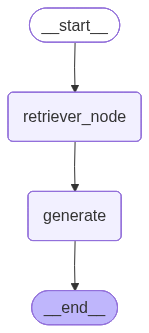

In [10]:
# add modes
def retriever_node(state:ragState):
    ret_docs = retriever.invoke(state["question"])
    return {"context":ret_docs}

# generation node
def generate(state:ragState):
    doc_content = "\n\n".join(doc.page_content for doc in state["context"])
    message = ragprompt.invoke({"question":state["question"],"context":doc_content})
    response = llm.invoke(message)
    return {"answer":response}

builder = StateGraph(ragState).add_sequence([retriever_node,generate])
builder.add_edge(START,"retriever_node")
builder.add_edge("generate",END)
raggraph = builder.compile()
raggraph

In [11]:
response = raggraph.invoke({"question":"what is large cap equity fund?"})

In [12]:
response['answer'].content

'A large cap equity fund primarily consists of stocks from the top 100 stocks by full market capitalization of the equity market. These funds invest at least 80% of their total assets in Indian equities, while the remaining can be allocated to other asset classes such as fixed income and overseas equities.'

## Relevance Evaluation of Retrieved Documents (Question-Retrieval Evaluation)

The relevance evaluation of retrieved documents is the step where the retrieved documents are assessed for their relevance to the question.

First, create an evaluator (```retrieval-grader```) to assess the retrieved documents.

In [13]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


# Data Model for Binary Scoring of Document Relevance
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved document."""

    # A field indicating whether the document is relevant to the question, represented as 'yes' or 'no'
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# An LLM that generates structured outputs using the GradeDocuments data model.
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Define system prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# Create chat prompt template
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Initialize retrieval evaluator
retrieval_grader = grade_prompt | structured_llm_grader

Using ```retrieval_grader```, documents are evaluated.

Here, the evaluation is performed on a single document rather than a set of documents.

The result returns the relevance of the single document as either **yes** or **no** .

In [14]:
# Define question
question = "How do agents differ from standalone language models?"

# Document retrieval
docs = retriever.invoke(question)

# Extract Content of Page from Document at Index 1
doc_txt = docs[0].page_content

# Run Relevance Evaluation Using Retrieved Documents and Question
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [15]:
# Define question
question = "What is Large cap equity fund?"

# Document retrieval
docs = retriever.invoke(question)

# Extract Content of Page from Document at Index 1
doc_txt = docs[0].page_content

# Run Relevance Evaluation Using Retrieved Documents and Question
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [16]:
prompt = ChatPromptTemplate.from_messages(
    [        ("human", "Given a query, classify it as positive or negative sentiment. here is the query {query}"),
    ]
)

chain = prompt | llm

chain.invoke({"query":"It was an awesome day today"})

AIMessage(content='The sentiment of the query "It was an awesome day today" is positive.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 29, 'total_tokens': 46, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CISPjf2UyJwyacHJovsxyCryU3dnj', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'

In [17]:
prompt = ChatPromptTemplate.from_messages(
    [        ("human", "Given a query, classify it as positive or negative sentiment. here is the query {query} Make sure your response is in one word, positive or negative"),
    ]
)

chain = prompt | llm

output = chain.invoke({"query":"It was an awesome day today"}).content
print(output)
type(output)

Positive


str

In [18]:
from pydantic import BaseModel, Field

class sentiment_output(BaseModel):
    sentiment:str = Field(description="Sentiment associated with the query, output should be positive or negative")

structured_llm = llm.with_structured_output(sentiment_output)


prompt = ChatPromptTemplate.from_messages(
    [        ("human", "Given a query, classify it as positive or negative sentiment. here is the query {query} Make sure your response is in one word, positive or negative"),
    ]
)

chain = prompt | structured_llm

output = chain.invoke({"query":"It was an awesome day today"})
print(output)
type(output)

sentiment='positive'


__main__.sentiment_output

In [19]:
output.sentiment

'positive'

## Web search tool

**Web search tool** is used to supplement the context.

- **Need for Web Search**: When all documents fail to meet the relevance threshold or the evaluator lacks confidence, additional data is retrieved through web searches.
- **Using Tavily Search**: Perform web searches using Tavily Search, which optimizes search queries and provides more relevant results.
- **Question Rewrite**: Improve search queries by rewriting the question to optimize web searches.

Add this to .env file (remove '-Anshu' from end): TAVILY_API_KEY=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-Anshu

In [20]:
# Initialize Web Search Tool
from langchain.tools.tavily_search import TavilySearchResults

# Set maximum search results to 3
web_search_tool = TavilySearchResults(max_results=3)

/tmp/ipykernel_6331/1329910383.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(max_results=3)


In [21]:
# Execute web search tool
results = web_search_tool.invoke({"query": question})
print(results)

[{'title': 'Basics, Important Features of Large-cap Mutual Fund - Groww', 'url': 'https://groww.in/mutual-funds/equity-funds/large-cap-funds', 'content': '— Paperless sign up on web & app\n\n— Expert recommendations\n\n— ZERO fees !\n\n## What are Large Cap Funds?\n\nLarge Cap Mutual Funds are equity funds that invest a bigger proportion of their total assets in companies with a large market capitalisation. These companies are highly reputed and have an excellent track record of generating wealth for their investors over a long period. [...] By now, you know that large cap funds invest in big organisations. These schemes try to offer regular dividends and capital appreciation in the long term. If you are a risk-averse investor but want to benefit from equity investments, then large cap equity funds are the best option available to you. Since these schemes invest in financially strong large cap companies, they can withstand a slowdown in the markets. However, the returns are lower compa

## State

Define the state for the CRAG graph.

```Web_search``` represents the state indicating whether to use web search.
It is expressed as yes or no (yes: web search required, no: not required).

In [46]:
from typing import Annotated, List
from typing_extensions import TypedDict

# Define State
class GraphState(TypedDict):
    question: Annotated[str, "The question to answer"]
    generation: Annotated[str, "The generation from the LLM"]
    web_search: Annotated[str, "Whether to add search"]
    documents: Annotated[List[str], "The documents retrieved"]
    refined_for_re_retrieval:bool
    relevant:bool
    answer:str
    refined_query: str
    web_search_query:str
    

## Node

Define the nodes to be used in the CRAG graph.

In [47]:
from langchain.schema import Document
from langgraph.graph import StateGraph, END


# Document Retrieval Node
def retrieve(state: GraphState):
    print("\n==== RETRIEVE ====\n")
    if state['refined_for_re_retrieval']:
        question = state["refined_query"]
    else:
        question = state["question"]

    # Perform document retrieval.
    documents = retriever.invoke(question)
    return {"documents": documents}


# Answer Generation Node
def generate(state: GraphState):
    print("\n==== GENERATE ====\n")
    context = "\n".join([doc.page_content for doc in state["documents"]])
    message = ragprompt.invoke({"question":state["question"],"context":context})
    response = llm.invoke(message)
    print("Response: ",response)
    return {"answer": response}

In [48]:
from pydantic import BaseModel, Field

class graderResponseStructure(BaseModel):
    grader_score:str = Field(description="documents are relevant to the query or not, 'yes' or 'no'")


graderLLM = llm.with_structured_output(graderResponseStructure)
# Document Evaluation Node
def grade_documents(state: GraphState):
    print("\n==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====\n")

    prompt = PromptTemplate.from_template("""
    You are an expert grader, kindly evaluate provided documents and its relevance to the user query, if the docs are related to the question, then it is relevant, return 'yes' or else return 'no'
    Are the following documents relevant to the query?
    Query: {query}
    Documents: {docs}
    Answer "YES" or "NO".
    """)
    formatted_docs = "\n".join([doc.page_content for doc in state["documents"]])
    result = graderLLM.invoke(prompt.format(query=state["question"], docs=formatted_docs))
    is_relevant = "yes" in result.grader_score.lower()
    return {
        "question": state["question"],
        "documents": state["documents"],
        "relevant": is_relevant,
        "refined_for_re_retrieval": state.get("refined_for_re_retrieval")
    }


In [49]:
qus = "what is mid cap capital market?"
docs = retrieve({"question":qus,"refined_for_re_retrieval":False})
grade_documents({"question":qus,"documents":docs['documents']})


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====



{'question': 'what is mid cap capital market?',
 'documents': [Document(id='7a8f3a52-6150-49d4-b58a-7d5bded04f24', metadata={'page_label': '1', 'source': 'https://www.morningstar.in/docs/methodology/CategoryDefinitionsIndiaV3.pdf', 'creator': 'PScript5.dll Version 5.2.2', 'title': 'Microsoft Word - India Category_Definitions April 2021', 'total_pages': 12, 'creationdate': '2021-02-26T12:11:18+05:30', 'page': 0, 'start_index': 0, 'author': 'KBelapu', 'producer': 'GPL Ghostscript 9.06', 'moddate': '2021-02-26T12:11:18+05:30'}, page_content='? \n \n \n \n \n \n \n \n \n \n \n \nCategor y Definitions  \nIndia \nEquity  \n \nLarge-Cap \nLarge-Cap funds primarily consist of stocks which are the Top 100 stocks by full market capitalization  of \nthe equity market. These funds invest at least 80% of total assets in Indian equities and the balance can \nbe invested in other asset classes such as fixed income and overseas equities, among others. Funds in \nthis category would invest at least 80%

In [57]:

# Query Rewriting Node
def query_rewrite(state: GraphState):
    print("\n==== [REWRITE QUERY] ====\n")
    question = state["question"]

    if not state.get("refined_for_re_retrieval"): # for first time query finetuning for Vector DB
        prompt = f"Generate 5 improved variants of the following query in context to finance, stock markets: {question}"
        response = llm.invoke(prompt)
        improved_query = question + " " + " ".join(response.content.split("\n"))
        return {"refined_query": improved_query, "refined_for_re_retrieval": True}
    else:
        # Rewrite the question.
        prompt = f"Write a short query optimized for web search for the provided question: {question}"
        web_query = llm.invoke(prompt)
        print("WEB Query: ",web_query)
        return {"web_search_query": web_query.content, "web_search": True}

# Web Search Node
def web_search(state: GraphState):
    print("\n==== [WEB SEARCH] ====\n")
    question = state["web_search_query"]
    documents = state['documents']

    # Perform web search.
    docs = web_search_tool.invoke({"query": question})
    # Convert search results into document format.
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents}



## Function for Conditional Edges

The ```decide_to_generate``` function routes to the next node based on whether web search is required after relevance evaluation.

If ```web_search``` is ```Yes```, it rewrites the query at the ```query_rewrite``` node and performs a web search.

If ```web_search``` is ```No```, it proceeds to ```generate``` to create the final answer.


## Graph Creation

Now, define the nodes and connect the edges to complete the graph.

Visualize the graph.

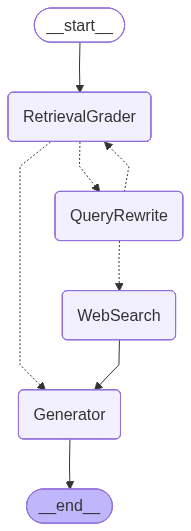

In [58]:
# ---- Subgraph: Retrieval + Grading ----
def build_retrieval_grader_subgraph():
    sub_builder = StateGraph(GraphState).add_sequence([retrieve,grade_documents])
    sub_builder.add_edge(START,"retrieve")
    sub_builder.add_edge("grade_documents", END)
    return sub_builder.compile()

retrieval_grader = build_retrieval_grader_subgraph()


# ---- Main Graph ----
builder = StateGraph(GraphState)

builder.add_node("RetrievalGrader", retrieval_grader)
builder.add_node("Generator", generate)
builder.add_node("QueryRewrite", query_rewrite)
builder.add_node("WebSearch", web_search)

builder.set_entry_point("RetrievalGrader")

# ---- Routing Logic ----
def route_after_grading(state: GraphState) -> str:
    if state["relevant"]:
        return "Generator"
    elif not state["refined_for_re_retrieval"]:
        return "QueryRewrite"
    else:
        return "QueryRewrite"

def route_after_rewrite(state: GraphState) -> str:
    if state.get("web_search"):
        return "WebSearch"
    return "RetrievalGrader"

builder.add_conditional_edges("RetrievalGrader", route_after_grading,{"Generator":"Generator",
                                                                      "QueryRewrite":"QueryRewrite",
                                                                      })
builder.add_edge("Generator", END)
builder.add_conditional_edges("QueryRewrite", route_after_rewrite,{"WebSearch":"WebSearch","RetrievalGrader":"RetrievalGrader"})
builder.add_edge("WebSearch", "Generator")

graph = builder.compile()

graph

In [59]:
# ---- Execute Graph ----
response = graph.invoke({"question": "What is LangGraph and how is it used?","refined_for_re_retrieval":False})
print("Final Answer:", response.get("answer"))


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


==== [REWRITE QUERY] ====


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


==== [REWRITE QUERY] ====

WEB Query:  content='"LangGraph overview and usage guide"' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 30, 'total_tokens': 39, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CIStJUDq74oEEu5QH0WV0kiIl6RX7', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered'

In [65]:
# ---- Execute Graph ----
response = graph.invoke({"question": "What is mid market?","refined_for_re_retrieval":False})
print("Final Answer:", response.get("answer"))


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


==== [REWRITE QUERY] ====


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


==== GENERATE ====

Response:  content='Mid market refers to the category of Mid-Cap funds, which primarily consist of stocks ranked 101st to 250th by full market capitalization of the equity market. These funds invest at least 65% of total assets in Indian equities.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 1079, 'total_tokens': 1129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CISvR6Od5WRh1d9KoFkroBgDhvI19', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_

In [64]:
# ---- Execute Graph ----
response = graph.invoke({"question": "what is large cap capital market?","refined_for_re_retrieval":False})
print("Final Answer:", response.get("answer"))


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


==== GENERATE ====

Response:  content='Large cap capital market refers to the segment of the equity market comprising the top 100 stocks by full market capitalization. Large-cap funds invest at least 80% of their total assets in these large-cap stocks, while the remainder may be allocated to other asset classes like fixed income and overseas equities.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 1081, 'total_tokens': 1141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CISv3bh0Q6FoQgFfTrWXoHAUYLB4p', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'h